In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from matplotlib.colors import LogNorm 
from matplotlib import ticker
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
from scipy.linalg import lu_factor, lu_solve
from scipy.sparse import coo_array, block_diag
from scipy.signal import butter, filtfilt
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from scipy import signal
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline
import ipywidgets as widgets
from PIL import Image
import os
eps = np.finfo(float).eps


In [2]:
import empymod

In [3]:
from masa_utils import TEM_Signal_Process
from masa_utils import PsuedoLog


Simulatin and synthetic study on deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019).
On-Time: 200msec
ramp time: 200usec
Transmitter Loop: 3.5m Square Loop
Receiver Loop: Coincident-type
Number of Turn: 5
3.5m rectangular loop has equivalent area for 2.0m circular. 

In [4]:
base_freq=1.25
on_time=200e-3
rmp_time=200e-6
rec_time=5e-3
smp_freq=50e3 #200e3  


In [5]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumeference = 2*np.pi*tx_radius
tx_surface = np.pi*tx_radius**2
n_turns = 5
tx_depth = 0
print(f"Transmitter radius: {tx_radius}")

Transmitter radius: 1.9746635424171473


In [6]:
csx, csz = tx_radius/4.,tx_radius/4.
con_sea = 3.0
res_sea = 1/con_sea
res0_target = 0.15
con_target = 1/res0_target
eta_sea , eta_base = 0.,0.
eta_target = 0.3
con8_target = con_target/(1-eta_target)
print(f'con8 {con8_target:.2e}')
print(f'con  {con_target:.2e}')
tau_sea, tau_base, tau_ref = 1.0e-2, 1.0e-2, 1.0e-2
tau_target = 1.0e-3
c_target = 0.8
c_sea, c_base, c_ref = 0.6,0.6,0.6
thick_target = 30.
con_seabed = 1.0
res_seabed = 1/con_seabed
tx_height = csx
print(tx_height)


con8 9.52e+00
con  6.67e+00
0.4936658856042868


In [7]:
depth =  tx_height + np.r_[0, thick_target]
print(depth)

[ 0.49366589 30.49366589]


In [8]:
## Calculate time with 1/4 of the time steo for recored time steps
## use sampling frequency as 50kHz, ramp time of 200us (K. Nakayama and A. Saito,	2016)
tstrt, tend = 1e-4, 4e-3
logstep = 1/20

WISTEM_SP_sim = TEM_Signal_Process (
    base_freq=base_freq,
    on_time=on_time,
    rmp_time=rmp_time,
    rec_time=tend,
    smp_freq=smp_freq*4,
)
times_clc = WISTEM_SP_sim.times_rec
ntimes = len(times_clc)
print(ntimes)
print(times_clc[:3], times_clc[-3:])
filt_rmp = WISTEM_SP_sim.filter_linear_rmp()
windows_cen, windows_strt, windows_end=WISTEM_SP_sim.get_window_log(
    logstep=logstep,tstart=tstrt ,tend=tend)
Window_mat = WISTEM_SP_sim.get_window_matrix(times=times_clc)
print(Window_mat.shape)

800
[5.0e-06 1.0e-05 1.5e-05] [0.00399  0.003995 0.004   ]
(32, 800)


In [9]:
nlayer = 1


In [10]:
res = res0_target * np.ones(nlayer)
m_r = np.log(res)
m = eta_target * np.ones(nlayer)
m_m = m 
m_t = np.log(tau_target)*np.ones(nlayer)
m_c = c_target*np.ones(nlayer)
mvec_obs = np.r_[m_r, m_m,m_t,m_c]
print(mvec_obs)


[-1.89711998  0.3        -6.90775528  0.8       ]


In [11]:
# Prj_m = np.zeros((4*(nlayer+nlayer_fix),4*nlayer))
# nlayer_sum = nlayer+nlayer_fix
# for i in range (4):
#     irow = i * nlayer_sum  
#     icol = i * nlayer
#     Prj_m[irow+1 : irow + 1 + nlayer, icol:icol+nlayer] = 1.0
# print(Prj_m.shape)
# print(Prj_m)

In [12]:
# nlayer = 2
# nlayer_fix = 2
# nlayer_sum = nlayer+nlayer_fix
# Prj_m_each = np.block([
#     [np.zeros(nlayer)],
#     [np.eye(nlayer)],
#     [np.zeros(nlayer)],
# ])
# Prj_m=np.block([
#     [Prj_m_each, np.zeros((nlayer_sum, 3*nlayer))],
#     [np.zeros((nlayer_sum,  nlayer)), Prj_m_each, np.zeros((nlayer_sum, 2*nlayer))],
#     [np.zeros((nlayer_sum,2*nlayer)), Prj_m_each, np.zeros((nlayer_sum, nlayer))],
#     [np.zeros((nlayer_sum,3*nlayer)), Prj_m_each],
# ])


In [14]:
m_fix = np.r_[ np.log(res_sea), np.zeros(nlayer), np.log(res_seabed),
   np.zeros(nlayer+nlayer_fix),
   np.log(tau_sea),np.zeros(nlayer), np.log(tau_base),
   c_sea,np.zeros(nlayer),c_base]
print(m_fix.shape)
print(m_fix)

NameError: name 'nlayer_fix' is not defined

In [ ]:
// parm = m_fix + Prj_m@mvec_obs
// print(np.exp(parm[:nlayer_sum]))
// print((parm[nlayer_sum:2*nlayer_sum]))
// print(np.exp(parm[2*nlayer_sum:3*nlayer_sum]))
// print(parm[3*nlayer_sum:4*nlayer_sum])

[0.33333333 0.15       1.        ]
[0.  0.3 0. ]
[0.01  0.001 0.01 ]
[0.6 0.8 0.6]


In [15]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_bdple = {
    # simulate each bipole of four side of the transmitter loop
    'src': [   tx_side/2, tx_side/2, -tx_side/2,tx_side/2, tx_depth,  tx_depth], 
    # receiver at the center of the transmitter loop
    'freqtime' : times_clc,
    'rec': [ 0,0,tx_depth,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
#    'freqtime': time_empymod,
    'signal': 0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': n_turns* tx_surface* 8* mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [16]:
class empymod_IPinv:

    def __init__(self, model_base, nlayer,
        m_ref=None, nD=0, nlayer_fix=0, Prj_m=None, m_fix=None,
        resmin=1e-3 , resmax=1e6, chgmin=1e-3, chgmax=0.9,
        taumin=1e-6, taumax=1e-1, cmin= 0.4, cmax=0.9,
        Wd = None, Ws=None, Wx=None, alphax=None, alphas=None,
        cut_off=None,filt_curr = None,  window_mat = None
        ):
        self.model_base = model_base
        self.nlayer = int(nlayer)
        self.nlayer_fix = int(nlayer_fix)
        self.nP = 4*(nlayer + nlayer_fix)
        self.m_ref = m_ref
        self.Prj_m = Prj_m  
        self.m_fix = m_fix
        if Prj_m is not None:
            assert Prj_m.shape[0] == self.nP
            self.nM = Prj_m.shape[1]
        else:
            self.Proj_m = np.eye(self.nP)
            self.nM = self.nP
            self.m_fix = np.zeros(self.nP)       
        self.nD = nD
        self.resmin = resmin
        self.resmax = resmax
        self.chgmin = chgmin
        self.chgmax = chgmax
        self.taumin = taumin
        self.taumax = taumax
        self.cmin = cmin
        self.cmax = cmax
        self.Wd = Wd
        self.Ws = Ws
        self.Wx = Wx
        self.alphax = alphax
        self.alphas = alphas
        self.cut_off = cut_off
        self.filt_curr = filt_curr
        self.window_mat = window_mat

    def get_param(self, param, default):
        return param if param is not None else default

    def fix_sea_basement(self, res_sea, res_base, 
                chg_sea, chg_base, tau_sea, tau_base, c_sea, c_base):
        ## return and set mapping for fixigin sea and basement resistivity
        ## Assert there are no fix ing at this stage
        nlayer = self.nlayer
        nlayer_fix=2
        nlayer_sum = nlayer+nlayer_fix
        Prj_m_A = np.block([
            [np.zeros(nlayer)], # sea water
            [np.eye(nlayer)], # layers
            [np.zeros(nlayer)], # basement
        ])
        Prj_m=np.block([
        [Prj_m_A, np.zeros((nlayer_sum, 3*nlayer))], # Resistivity
        [np.zeros((nlayer_sum,  nlayer)), Prj_m_A, np.zeros((nlayer_sum, 2*nlayer))], # Chargeability
        [np.zeros((nlayer_sum,2*nlayer)), Prj_m_A, np.zeros((nlayer_sum, nlayer))], # Time constant
        [np.zeros((nlayer_sum,3*nlayer)), Prj_m_A], # Exponent C
        ])
        m_fix = np.r_[ 
        np.log(res_sea), np.zeros(nlayer), np.log(res_base), # Resistivity
        chg_sea, np.zeros(nlayer), chg_base, # Chargeability
        np.log(tau_sea),np.zeros(nlayer), np.log(tau_base), # Time constant
        c_sea,np.zeros(nlayer),c_base # Exponent C
        ]
        assert len(m_fix) == 4*nlayer_sum
        self.nlayer_fix = nlayer_fix
        self.Prj_m = Prj_m
        self.m_fix = m_fix
        self.nP= Prj_m.shape[0]
        self.nM= Prj_m.shape[1]
        assert self.nP == 4*(nlayer+nlayer_fix)
        assert self.nM == 4*nlayer
        return Prj_m, m_fix

    def pelton_et_al(self, inp, p_dict):
        """ Pelton et al. (1978)."""

        # Compute complex resistivity from Pelton et al.
        iotc = np.outer(2j * np.pi * p_dict['freq'], inp['tau']) ** inp['c']
        rhoH = inp['rho_0'] * (1 - inp['m'] * (1 - 1 / (1 + iotc)))
        rhoV = rhoH * p_dict['aniso'] ** 2

        # Add electric permittivity contribution
        etaH = 1 / rhoH + 1j * p_dict['etaH'].imag
        etaV = 1 / rhoV + 1j * p_dict['etaV'].imag
        return etaH, etaV

    def get_ip_model(self, mvec):
        Prj_m = self.Prj_m
        m_fix = self.m_fix
        nlayer= self.nlayer
        nlayer_fix = self.nlayer_fix
        nlayer_sum = nlayer + nlayer_fix
        param = Prj_m @ mvec + m_fix
        res = np.exp(param[            :   nlayer_sum])
        m   =        param[  nlayer_sum: 2*nlayer_sum]
        tau = np.exp(param[2*nlayer_sum: 3*nlayer_sum])
        c   =        param[3*nlayer_sum: 4*nlayer_sum]
        pelton_model = {'res': res, 'rho_0': res, 'm': m,
                        'tau': tau, 'c': c, 'func_eta': self.pelton_et_al}
        return pelton_model

    def predicted_data(self, model_vector):
        cut_off = self.cut_off
        filt_curr = self.filt_curr
        window_mat = self.window_mat
        ip_model = self.get_ip_model(model_vector)
        data = empymod.bipole(res=ip_model, **self.model_base)
        self.nD = len(data)
        if cut_off is not None:
            times = self.model_base['freqtime']
            smp_freq = 1/(times[1]-times[0])
            data_LPF = self.apply_lowpass_filter(
                       data=data,cut_off=cut_off,smp_freq=smp_freq
                       )
            data = data_LPF
        if filt_curr is not None:
            data_curr = signal.convolve(data_LPF, filt_curr)[:len(data)]
            data = data_curr
        if window_mat is not None:
            data_window = window_mat @ data_curr
            self.nD = len(data_window)
            data = data_window
        return data
   
    def apply_lowpass_filter(self, data, cut_off,smp_freq, order=1):
        nyquist = 0.5 * smp_freq
        normal_cutoff = cut_off / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

    def projection_halfspace(self, a, x, b):
        projected_x = x + a * ((b - np.dot(a, x)) / np.dot(a, a)) if np.dot(a, x) > b else x
        # Ensure scalar output if input x is scalar
        if np.isscalar(x):
            return float(projected_x)
        return projected_x

    def proj_c(self,mvec):
        "Project model vector to convex set defined by bound information"
        nlayer = self.nlayer
        a = np.r_[1]
        print(mvec)
        for j in range(nlayer):
            r_prj = mvec[j]
            m_prj = mvec[j+   nlayer]
            t_prj = mvec[j+ 2*nlayer]
            c_prj = mvec[j+ 3*nlayer]
            r_prj = float(self.projection_halfspace( a, r_prj,  np.log(self.resmax)))
            r_prj = float(self.projection_halfspace(-a, r_prj, -np.log(self.resmin)))
            m_prj = float(self.projection_halfspace( a, m_prj,  self.chgmax))
            m_prj = float(self.projection_halfspace(-a, m_prj, -self.chgmin))
            t_prj = float(self.projection_halfspace( a, t_prj,  np.log(self.taumax)))
            t_prj = float(self.projection_halfspace(-a, t_prj, -np.log(self.taumin)))
            c_prj = float(self.projection_halfspace( a, c_prj,  self.cmax))
            c_prj = float(self.projection_halfspace(-a, c_prj, -self.cmin))
            mvec[j         ] = r_prj
            mvec[j+  nlayer] = m_prj
            mvec[j+2*nlayer] = t_prj
            mvec[j+3*nlayer] = c_prj
        return mvec
    
    def clip_model(self, mvec):
        mvec_tmp = mvec.copy()
        nlayer = self.nlayer
        mvec_tmp[        :  nlayer]=np.clip(
            mvec[        :  nlayer], np.log(self.resmin), np.log(self.resmax)
            )
        mvec_tmp[  nlayer:2*nlayer]=np.clip(
            mvec[  nlayer:2*nlayer], self.chgmin, self.chgmax
            )
        mvec_tmp[2*nlayer:3*nlayer]=np.clip(
            mvec[2*nlayer:3*nlayer], np.log(self.taumin), np.log(self.taumax)
            )
        mvec_tmp[3*nlayer:4*nlayer]=np.clip(
            mvec[3*nlayer:4*nlayer], self.cmin, self.cmax
            )
        return mvec_tmp

    def Japprox(self, model_vector, perturbation=0.1, min_perturbation=1e-3):
        delta_m = min_perturbation  # np.max([perturbation*m.mean(), min_perturbation])
#        delta_m = perturbation  # np.max([perturbation*m.mean(), min_perturbation])
        J = []

        for i, entry in enumerate(model_vector):
            mpos = model_vector.copy()
            mpos[i] = entry + delta_m

            mneg = model_vector.copy()
            mneg[i] = entry - delta_m

            pos = self.predicted_data(mpos)
            neg = self.predicted_data(mneg)
            J.append((pos - neg) / (2. * delta_m))

        return np.vstack(J).T

    def get_Wd(self, dobs, dp=1, ratio=0.10, plateau=0):
        std = np.abs(dobs * ratio) ** dp + plateau
        Wd = np.diag(1 / std)
        self.Wd = Wd 
        return Wd

    def get_Ws(self):
        nlayer = self.nlayer
        nx = 4*nlayer
        Ws = np.diag(np.ones(nx))
        self.Ws = Ws
        return Ws

    def get_Wx(self):
        nlayer = self.nlayer
        if nlayer == 1:
            print("No smoothness for one layer model")
            Wx = np.zeros((4,4))
            self.Wx = Wx
            return Wx
        nx = nlayer - 1
        ny = nlayer
        Wx = np.zeros((4 * nx, 4 * ny))
        for i in range(4):
            Wx[i * nx:(i + 1) * nx, i * ny:(i + 1) * ny - 1] = -np.diag(np.ones(nx))
            Wx[i * nx:(i + 1) * nx, i * ny + 1:(i + 1) * ny] += np.diag(np.ones(nx))
        self.Wx = Wx
        return Wx

    def get_Wxx(self):

        e = np.ones(self.nlayers*4)

        p1 = np.ones(self.nlayers)
        p1[0] = 2
        p1[-1] = 0
        eup = np.tile(p1, 4)

        p2 = np.ones(self.nlayers)
        p2[0] = 0
        p2[-1] = 2
        edwn = np.tile(p2, 4)
        Wxx = np.diag(-2 * e) + np.diag(eup[:-1], 1) + np.diag(edwn[1:], -1)

        return Wxx

    def GaussNewton_smooth(self, dobs, mvec_init, niter,beta,
                           s0=1, sfac=0.5, stol=1e-6, gtol=1e-3, mu=1e-4):
        Wd = self.Wd
        Ws = self.Ws
        Wx = self.Wx
        alphas = self.alphas
        alphax = self.alphax
        mvec_old = mvec_init
        # applay initial mvec for reference mode
        mref = mvec_init
        # get noise part
        # Initialize object function
        rd = Wd @ (self.predicted_data(mvec_old) - dobs)
        phid = 0.5 * np.dot(rd, rd)
        rms = 0.5 * np.dot(mvec_old - mref, mvec_old - mref)
        rmx = 0.5 * np.dot(Wx @ mvec_old, Wx @ mvec_old)
        phim = alphas * rms + alphax * rmx
        f_old = phid + beta * phim
        # Prepare array for storing error and model in progress
        error_prg = np.zeros(niter + 1)
        mvec_prg = np.zeros((niter + 1, mvec_init.shape[0]))
        error_prg[0] = f_old
        mvec_prg[0, :] = mvec_old

        print(f'Gauss-Newton \n Initial phid = {phid:.2e} ,phim = {phim:.2e}, error= {f_old:.2e} ')
        for i in range(niter):

            # Jacobian
            J = self.Japprox(mvec_old)

            # gradient
            g = J.T @ Wd.T @ rd + beta * (alphas * Ws.T @ Ws @ (mvec_old - mref)
                                          + alphax * Wx.T @ Wx @ mvec_old)
            # Hessian approximation
            H = J.T @ Wd.T @ Wd @ J + beta * (alphas * Ws.T @ Ws + alphax * Wx.T @ Wx)

            # model step
            dm = np.linalg.solve(H, g)

            # End inversion if gradient is smaller than tolerance
            g_norm = np.linalg.norm(g, ord=2)
            if g_norm < gtol:
                print(f"Inversion complete since norm of gradient is small as :{g_norm :.3e} ")
                break

            # update object function
            s = s0
            mvec_new = self.clip_model(mvec_old - s * dm)
            rd = Wd @ (self.predicted_data(mvec_new) - dobs)
            phid = 0.5 * np.dot(rd, rd)
            rms = 0.5 * np.dot(mvec_new - mref, mvec_new - mref)
            rmx = 0.5 * np.dot(Wx @ mvec_new, Wx @ mvec_new)
            phim = alphas * rms + alphax * rmx
            f_new = phid + beta * phim

            # Backtracking method using directional derivative Amijo
            directional_derivative = np.dot(g, -dm)
            while f_new >= f_old + s * mu * directional_derivative:
                # backtracking
                s *= sfac
                # update object function
                mvec_new = self.clip_model(mvec_old - s * dm)
                rd = Wd @ (self.predicted_data(mvec_new) - dobs)
                phid = 0.5 * np.dot(rd, rd)
                rms = 0.5 * np.dot(Ws @ (mvec_new - mref), Ws @ (mvec_new - mref))
                rmx = 0.5 * np.dot(Wx @ mvec_new, Wx @ mvec_new)
                phim = alphas * rms + alphax * rmx
                f_new = phid + beta * phim
                # Stopping criteria for backtrackinng
                if s < stol:
                    break

            # Update model
            mvec_old = mvec_new
            mvec_prg[i + 1, :] = mvec_new
            f_old = f_new
            error_prg[i + 1] = f_new
            k = i + 1
            print(f'{k:3}, step:{s:.2e}, gradient:{g_norm:.2e}, phid:{phid:.2e}, phim:{phim:.2e}, f:{f_new:.2e} ')
        # clip progress of model and error in inversion
        error_prg = error_prg[:k]
        mvec_prg = mvec_prg[:k]

        return mvec_new, mvec_prg
    
    def objec_func(self,mvec,dobs,beta):
        Wd = self.Wd
        Ws = self.Ws
        Wx = self.Wx
        alphas = self.alphas
        alphax = self.alphax
        m_ref = self.m_ref
        rd = Wd @ (self.predicted_data(mvec) - dobs)
        phid = 0.5 * np.dot(rd, rd)
        rms = 0.5 * np.dot(Ws @ (mvec - m_ref), Ws @ (mvec - m_ref))
        rmx = 0.5 * np.dot(Wx @ mvec, Wx @ mvec)
        phim = alphas * rms + alphax * rmx
        f_obj = phid + beta * phim
        return f_obj, phid, phim

    def plot_model(self, model, ax, color='C0',linestyle='-', label="model", linewidth=1, depth_min=-100):
        depth = np.r_[depth_min+self.model_base["depth"][0], self.model_base["depth"]]
        depth_plot = np.vstack([depth, depth]).flatten(order="F")[1:]
        depth_plot = np.hstack([depth_plot, depth_plot[-1] * 1.5])
        model_plot = np.vstack([model, model]).flatten(order="F")
        ax.plot(model_plot, depth_plot,
             color=color, linestyle=linestyle, label=label,  linewidth=linewidth)
        return ax

    def plot_IP_par(self,mvec,color="orange", linestyle='-', label="",  linewidth=1.0,ax=None):
        if ax == None:
            fig, ax = plt.subplots(2, 2, figsize=(12, 8))

        # convert model vector to model
        model = self.get_ip_model(mvec)

    #    plot_model_m(model_base["depth"], model_ip["res"], ax[0], "resistivity","k")
        self.plot_model(model["res"], ax[0], color, linestyle=linestyle,label=label, linewidth=linewidth)

        self.plot_model(model["m"], ax[1], color, linestyle=linestyle,label=label, linewidth=linewidth)

        self.plot_model(model["tau"], ax[2],  color, linestyle=linestyle, label=label, linewidth=linewidth)

        self.plot_model(model["c"]  , ax[3],  color, linestyle=linestyle, label=label, linewidth=linewidth)

        ax[0].set_title("model_resistivity(ohm-m)")
        ax[1].set_title("model_changeability")
        ax[2].set_title("model_time_constant(sec)")
        ax[3].set_title("model_exponent_c")
        return ax

# empymod_IPinv and Forward simulation

In [ ]:
# DeepSea_TEMIP=empymod_IPinv(model_base=empymod_model_bdple, 
# nlayer=nlayer, nlayer_fix=nlayer_fix, Prj_m=Prj_m,m_fix=m_fix)


In [17]:
DeepSea_TEMIP=empymod_IPinv(model_base=empymod_model_bdple, nlayer=nlayer)
DeepSea_TEMIP.fix_sea_basement(
    res_sea=res_sea, res_base=res_seabed,
    chg_sea=eta_sea, chg_base=eta_base,
    tau_sea=tau_sea, tau_base=tau_base,
    c_sea=c_sea, c_base=c_base
    )


(array([[0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]]),
 array([-1.09861229,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -4.60517019,  0.        , -4.60517019,  0.6       ,
         0.        ,  0.6       ]))

In [18]:
dpred_step= DeepSea_TEMIP.predicted_data(mvec_obs)
DeepSea_TEMIP.cut_off = smp_freq/2.0
print(f"cutoff frequency: {DeepSea_TEMIP.cut_off}")
dpred_LPF = DeepSea_TEMIP.predicted_data(mvec_obs)
DeepSea_TEMIP.filt_curr = filt_rmp
dpred_rmp = DeepSea_TEMIP.predicted_data(mvec_obs)
DeepSea_TEMIP.window_mat=Window_mat
dpred_window = DeepSea_TEMIP.predicted_data(mvec_obs)
nD=DeepSea_TEMIP.nD

cutoff frequency: 25000.0


In [19]:
PL_decay = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2)

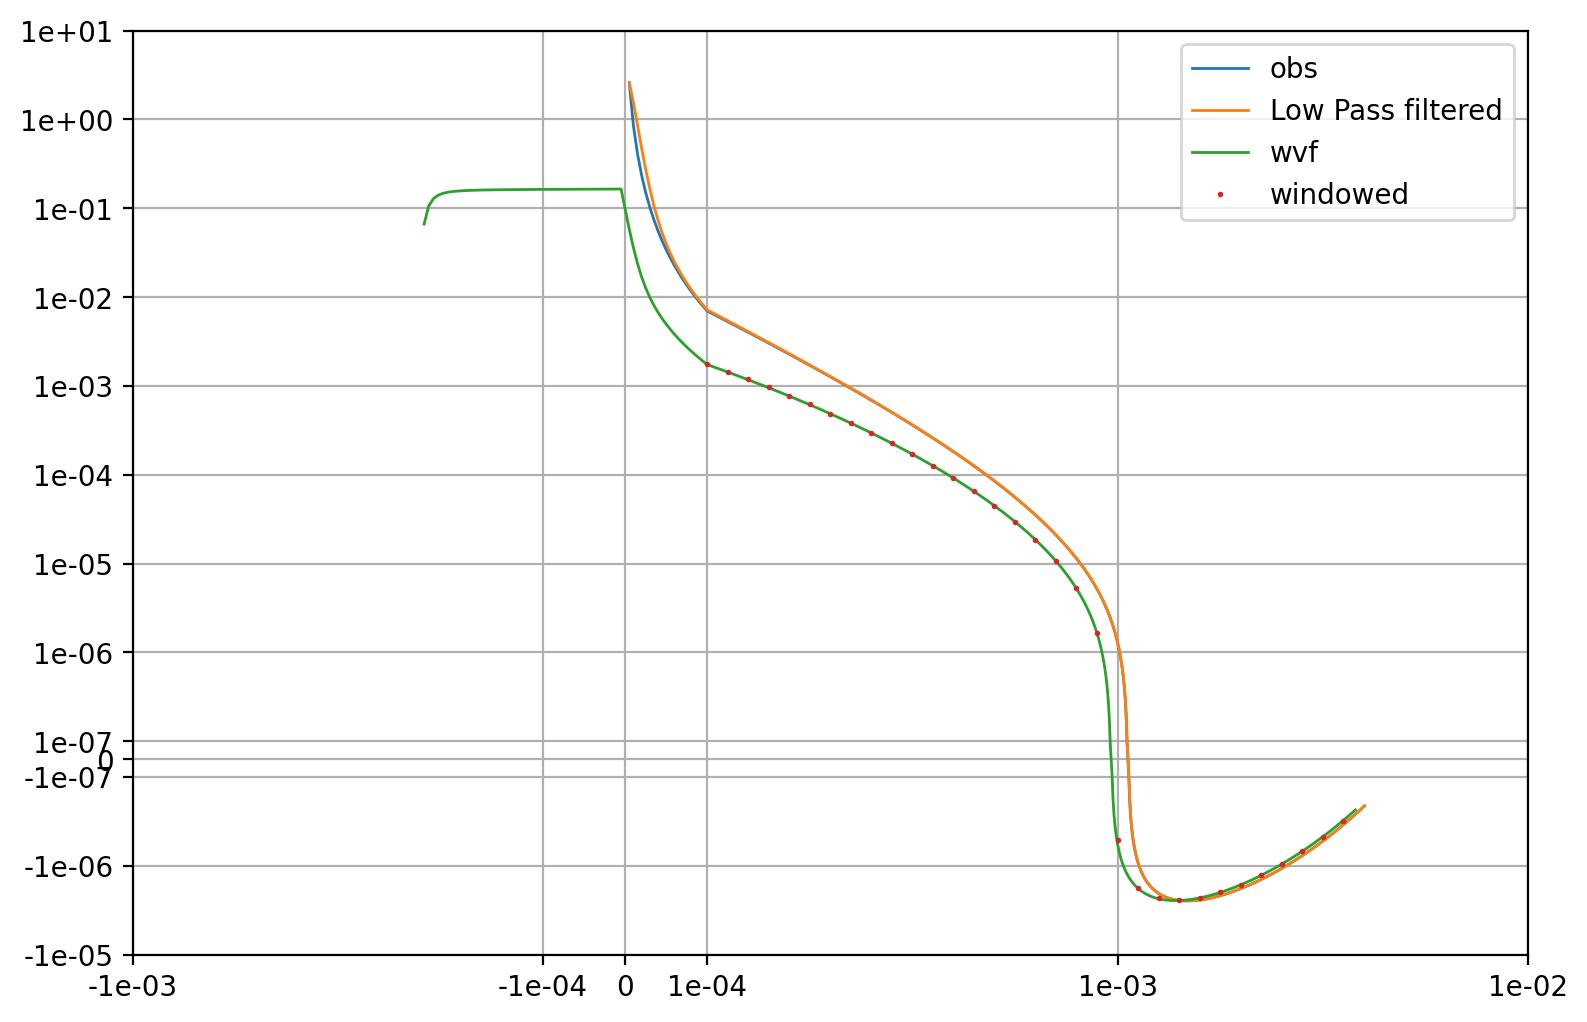

In [20]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)


ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


## Perform Synhetic Study

Data with relative error and noise floor

In [21]:
print(mvec_obs)
dobs_clean = DeepSea_TEMIP.predicted_data(mvec_obs)

[-1.89711998  0.3        -6.90775528  0.8       ]


In [22]:
relative_error=0.05
data_noise_floor = 1e-7
dobs_clean
np.random.seed(0)
dobs = ( dobs_clean
    + np.random.randn(len(dobs_clean)) * relative_error * np.abs(dobs_clean)
    + np.random.randn(len(dobs_clean)) * data_noise_floor
    )

Initial/Reference data

In [23]:
res = res_sea * np.ones(nlayer)
m_r = np.log(res)
m =  np.zeros(nlayer)
m_m = m 
m_t = np.log(tau_ref)*np.ones(nlayer)
m_c = c_ref*np.ones(nlayer)
mvec_ref = np.r_[m_r, m_m,m_t,m_c]
print(mvec_ref)
data_init = DeepSea_TEMIP.predicted_data(mvec_ref)


[-1.09861229  0.         -4.60517019  0.6       ]


Regularization

In [24]:
DeepSea_TEMIP.m_ref=mvec_ref
DeepSea_TEMIP.get_Wd(dobs=dobs,dp=1,ratio=relative_error,plateau=data_noise_floor)
DeepSea_TEMIP.get_Ws()
DeepSea_TEMIP.get_Wx()
DeepSea_TEMIP.alphas = 1e-2
DeepSea_TEMIP.alphax = 1.0


No smoothness for one layer model


Run inversion

In [25]:
niter = 15
beta = 10
stol= 1e-2
mu = 0.01
mvec_pred,  mvec_itr = DeepSea_TEMIP.GaussNewton_smooth(
    dobs=dobs, mvec_init=mvec_ref, niter=niter, beta=beta, 
    stol=stol,mu=mu
)

Gauss-Newton 
 Initial phid = 6.77e+03 ,phim = 0.00e+00, error= 6.77e+03 
  1, step:1.25e-01, gradient:6.60e+03, phid:3.97e+03, phim:7.98e-04, f:3.97e+03 
  2, step:6.25e-02, gradient:1.28e+04, phid:3.73e+03, phim:1.33e-03, f:3.73e+03 
  3, step:1.25e-01, gradient:1.59e+04, phid:3.53e+03, phim:2.07e-02, f:3.53e+03 
  4, step:2.50e-01, gradient:2.85e+04, phid:2.83e+03, phim:3.86e-02, f:2.83e+03 
  5, step:1.00e+00, gradient:5.55e+04, phid:4.70e+02, phim:2.74e-02, f:4.70e+02 
  6, step:1.00e+00, gradient:3.39e+04, phid:7.29e+01, phim:3.21e-02, f:7.32e+01 
  7, step:1.00e+00, gradient:1.41e+04, phid:7.49e+00, phim:3.05e-02, f:7.80e+00 
  8, step:1.00e+00, gradient:4.46e+02, phid:7.42e+00, phim:3.04e-02, f:7.73e+00 
  9, step:1.00e+00, gradient:5.21e-01, phid:7.42e+00, phim:3.04e-02, f:7.73e+00 
Inversion complete since norm of gradient is small as :5.269e-04 


In [26]:
data_pred = (DeepSea_TEMIP.predicted_data(mvec_pred))
cmp_itr = mvec_itr.shape[0]
data_itr = np.zeros((cmp_itr,len(data_pred)))
phid_itr = np.zeros(cmp_itr)
phim_itr = np.zeros(cmp_itr)
f_obj_itr = np.zeros(cmp_itr)
for i, mvec_tmp in enumerate(mvec_itr):
    data_itr[i,:] = DeepSea_TEMIP.predicted_data(mvec_tmp)
    f_obj_itr[i], phid_itr[i], phim_itr[i] = DeepSea_TEMIP.objec_func(mvec_tmp,dobs,beta)

# Plot results

In [27]:
# def plot_tikhonov_curves(phid_star=None, iteration=None, ax=None): 
#     if ax is None: 
#         fig, ax = plt.subplots(1, 1, figsize=(5,3))
#     ax.loglog(phim_itr, phid_itr)
#     ax.axhline(phid_star, color="k", linestyle="--", label="$\phi_d^*$")
#     if iteration is not None: 
#         ax.loglog(phim_itr[iteration], phid_itr[iteration], "C3o", label=f'beta={beta:1.1e}')
#     ax.set_ylabel("$\\phi_d$")
#     ax.set_xlabel("$\\phi_m$")
#     ax.set_title("Tikhonov Curve")
#     ax.legend()
#     ax.grid()
#     return ax

In [28]:
def plot_phid(phid_star=None, iteration=None, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    ax.semilogy(range(cmp_itr), phid_itr)
    ax.axhline(phid_star, color="k", linestyle="--", label="$\phi_d^*$")
    if iteration is not None: 
        ax.semilogy(iteration, phid_itr[iteration], "C3o", label=f'iteration: {iteration}')
    ax.set_xticks(np.arange(0,cmp_itr,np.ceil(cmp_itr/10))) 
    ax.set_ylabel("$\\phi_d$")
    ax.set_xlabel("Iteration")
    ax.set_title(f"Phid Curve, beta={beta:1.1e}")
    ax.legend()
    ax.grid()
    return ax

In [29]:
def plot_data(iteration, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen, data_init, ax=ax,
                       color="k",linewidth=2.0,label="reference"
                       )
    ax=PL_decay.semiply(windows_cen, dobs, ax=ax
                       ,color="b",linewidth=2.0, label="observation"
                       )
    ax=PL_decay.semiply(windows_cen, data_itr[iteration], ax=ax
                        ,color="r",linestyle="", marker="o",markersize=3.0
                        ,label=f"Estimated, iter={iteration}"
                        )
    PL_decay.min_y = -1e-5/2
    ax = PL_decay.pl_axes(ax)
    ax.grid()
    ax.legend()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")
    ax.set_title(f""" Data plot
Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e} V/A""")
    return ax

In [30]:
def plot_inversion_results(ind_show=0, ax=ax):
    fig = plt.figure(figsize=(11, 7))
    gs = gridspec.GridSpec(2, 4)  
    ax = [None] * 6

    ax[0] = fig.add_subplot(gs[0, 0])
    ax[1] = fig.add_subplot(gs[0, 1])
    ax[2] = fig.add_subplot(gs[1, 0])
    ax[3] = fig.add_subplot(gs[1, 1])
    ax[4] = fig.add_subplot(gs[0, 2:])
    ax[5] = fig.add_subplot(gs[1, 2:])
    axip =[ax[0], ax[1], ax[2], ax[3]]
    axip = DeepSea_TEMIP.plot_IP_par(mvec=mvec_ref,
         label="initial", color="k", linestyle="-", ax=axip, linewidth=3.0)
    axip = DeepSea_TEMIP.plot_IP_par(mvec=mvec_obs,
          label="true", color="b", linestyle="-", ax=axip, linewidth=3.0)
    axip = DeepSea_TEMIP.plot_IP_par(mvec=mvec_itr[ind_show],
         label="predicted",color="r",linestyle="--",ax=axip, linewidth=3.0)
    ax[0].set_xlim([1.1,0.09])
 
    for i in range(4):  # Iterate over rows
        ax[i].axhline(empymod_model_bdple["src"][4], color="g", linestyle="--", label="Src+Rec")
        ax[i].set_ylim([40, -10])
        ax[i].set_ylabel('depth')
        ax[i].legend()
        ax[i].grid()
        if i== 0 or i ==2:
            ax[i].set_xscale("log")
        else:
            ax[i].set_xscale("linear")       
    ax[4] = plot_data(iteration=ind_show, ax=ax[4])
    ax[5] = plot_phid(iteration=ind_show,phid_star=nD, ax=ax[5])
    plt.tight_layout()
    return ax


In [31]:
def plot_inversion_results_widgets(ind_show=0):
    plot_inversion_results(ind_show=ind_show)

widgets.interact(
    plot_inversion_results_widgets,
    ind_show=widgets.IntSlider(min=0, max=cmp_itr-1, value=0, continuous_update=False)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='ind_show', max=8), Output()), _…

<function __main__.plot_inversion_results_widgets(ind_show=0)>

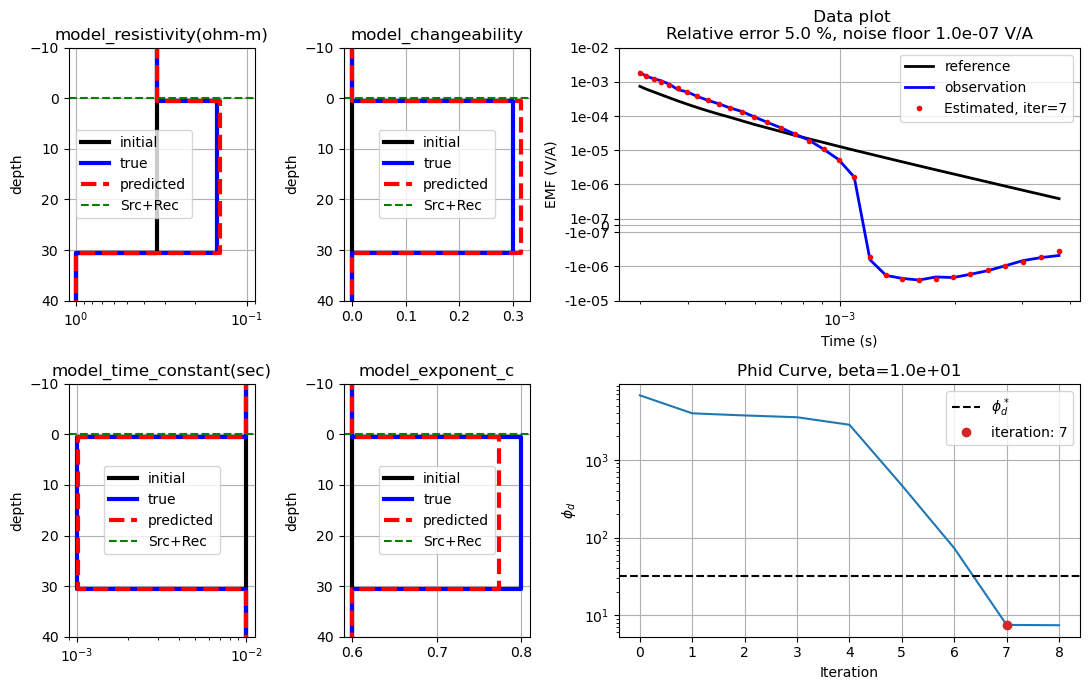

In [32]:
dpi = 300
plot_inversion_results_widgets(cmp_itr-2)
plt.savefig("51_Synthetic_Study_1DIP.png",dpi=dpi)


# Animation

In [ ]:
def save_all_fields_images(index_list, output_folder='images'):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for ind_save in index_list:
        # Create a new figure and axes for each time index
        plot_inversion_results(ind_show=ind_save)

        # Create a filename with zero padding (e.g., 001.png, 002.png)
        filename = f'{ind_save:03d}.png'
        # Save the figure to the output folder
        filepath = os.path.join(output_folder, filename)
        plt.savefig(filepath, format='png', dpi=dpi, bbox_inches='tight', pad_inches=0.1)
        
        # Close the figure to avoid display issues and free up memory
        plt.close(fig)

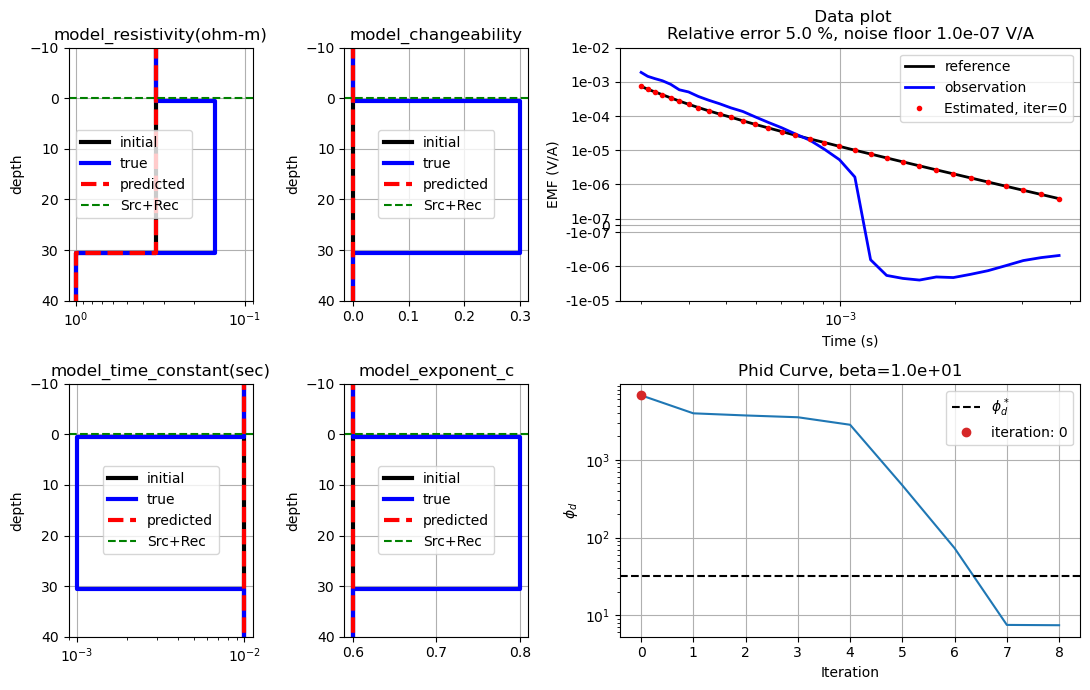

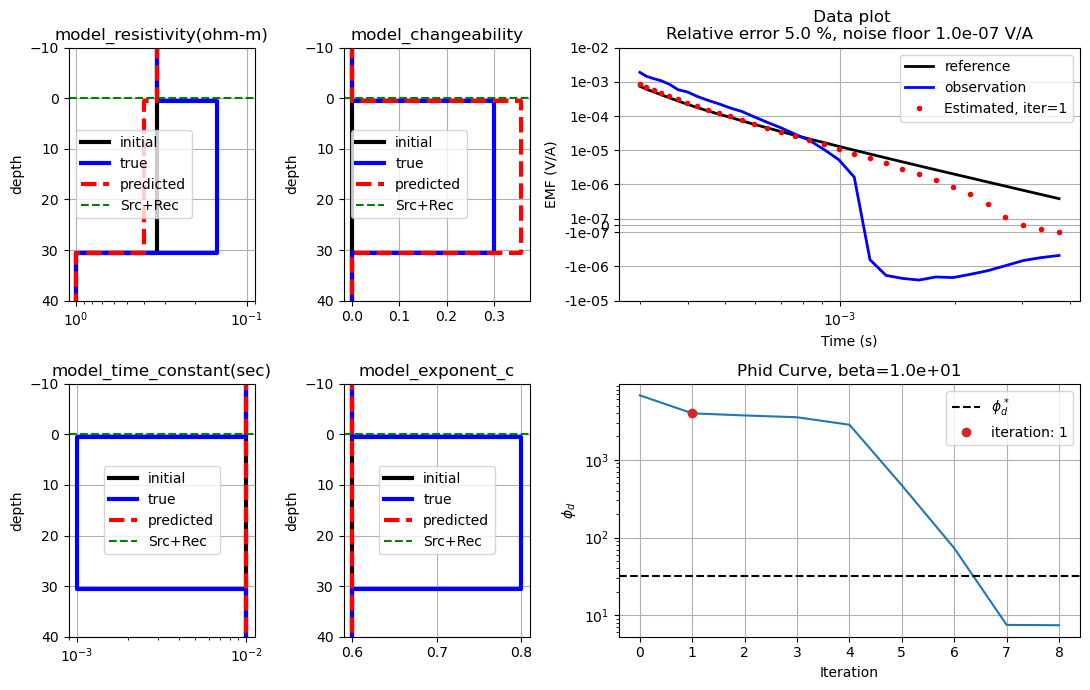

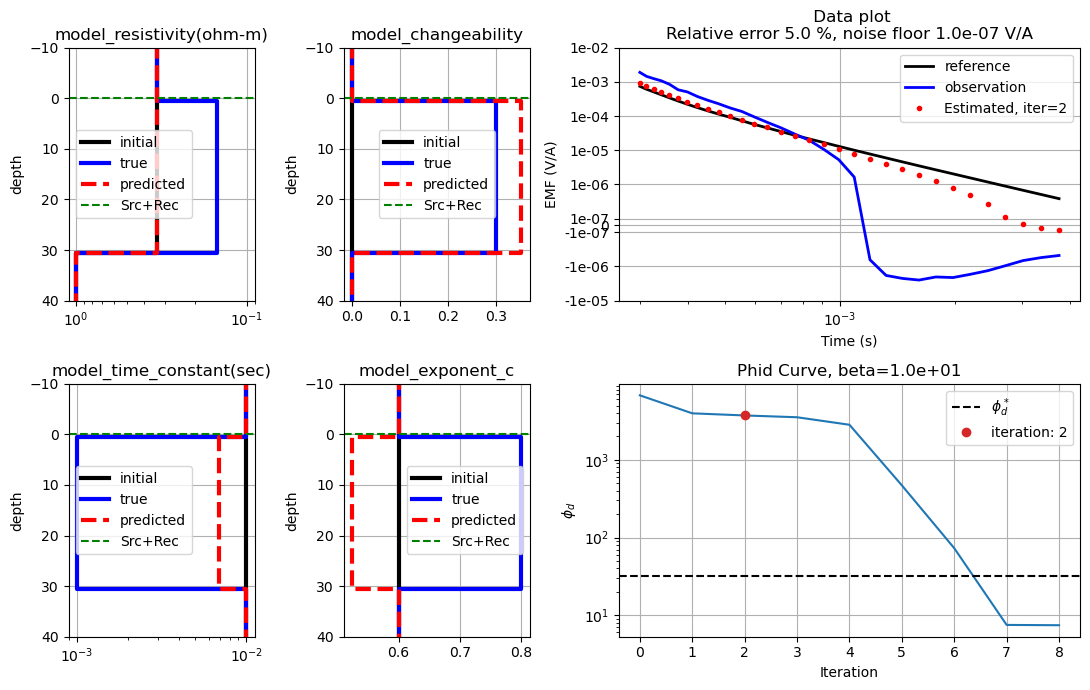

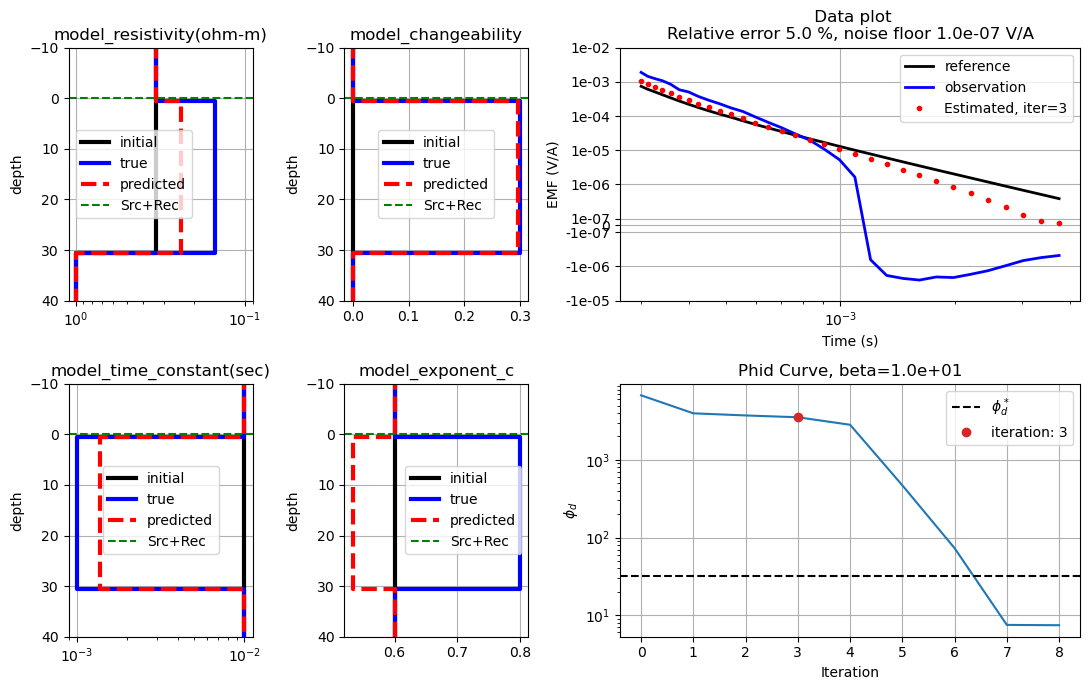

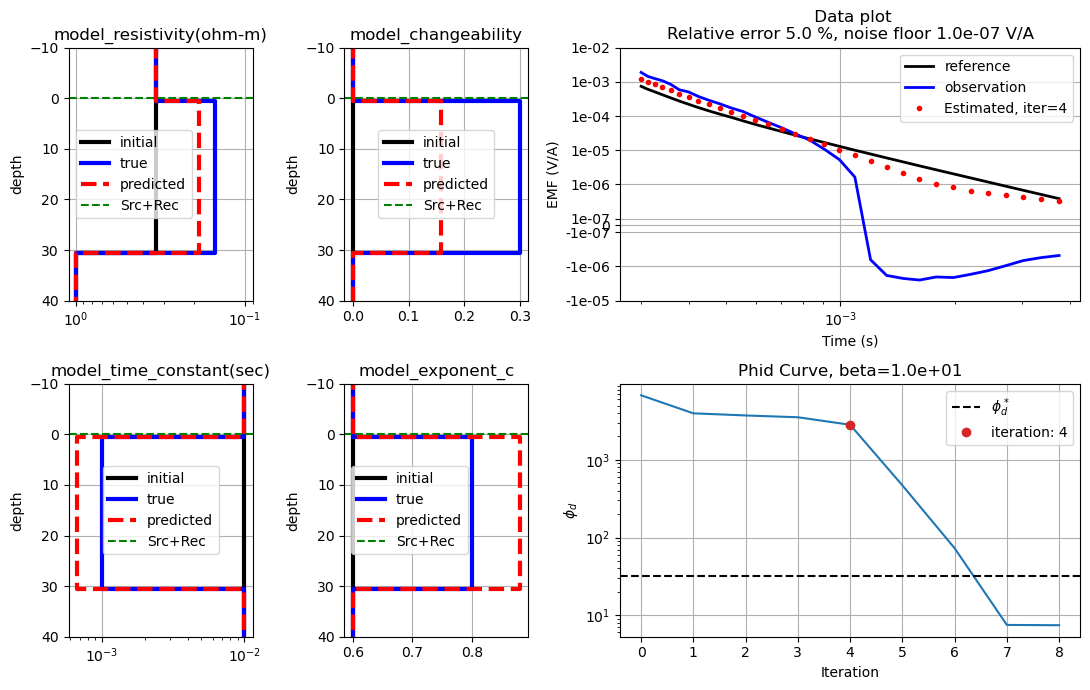

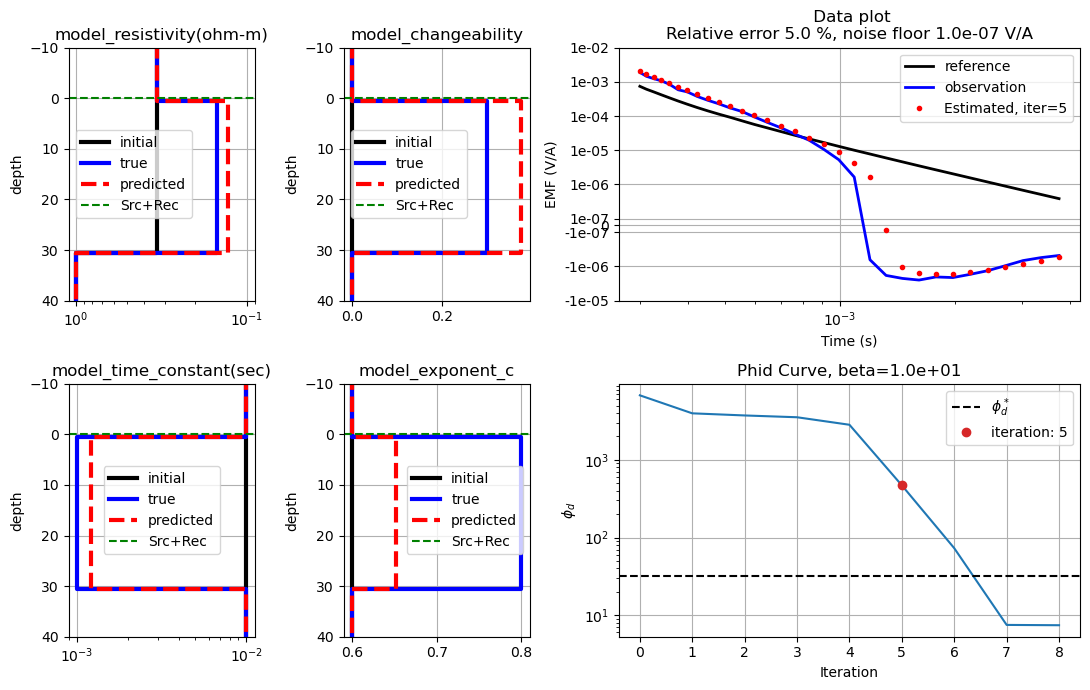

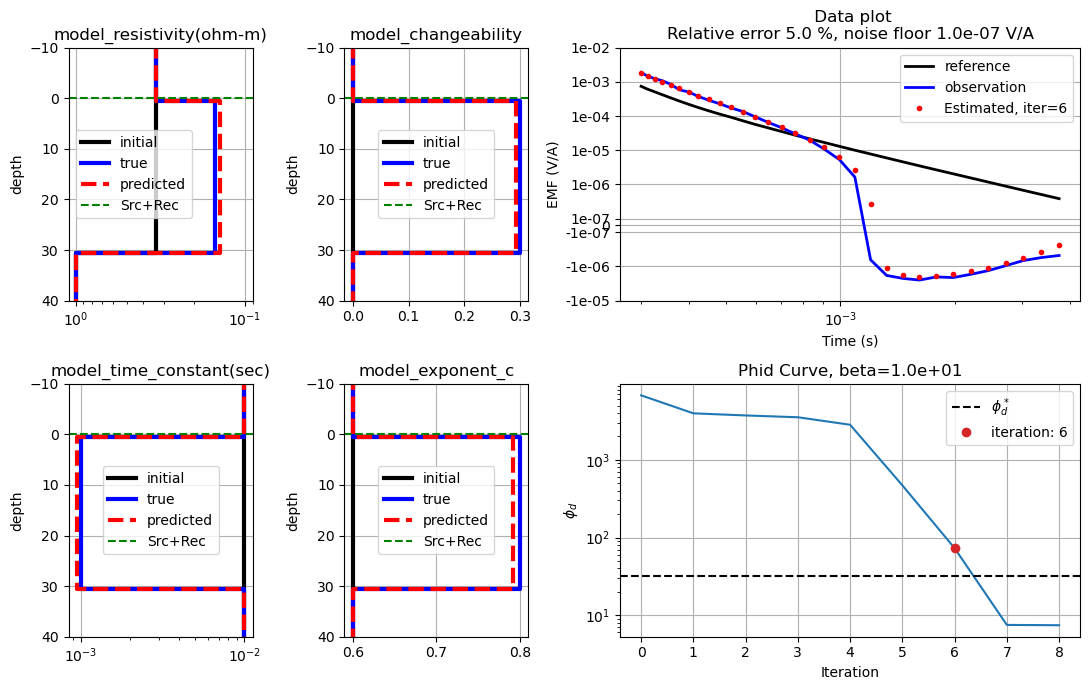

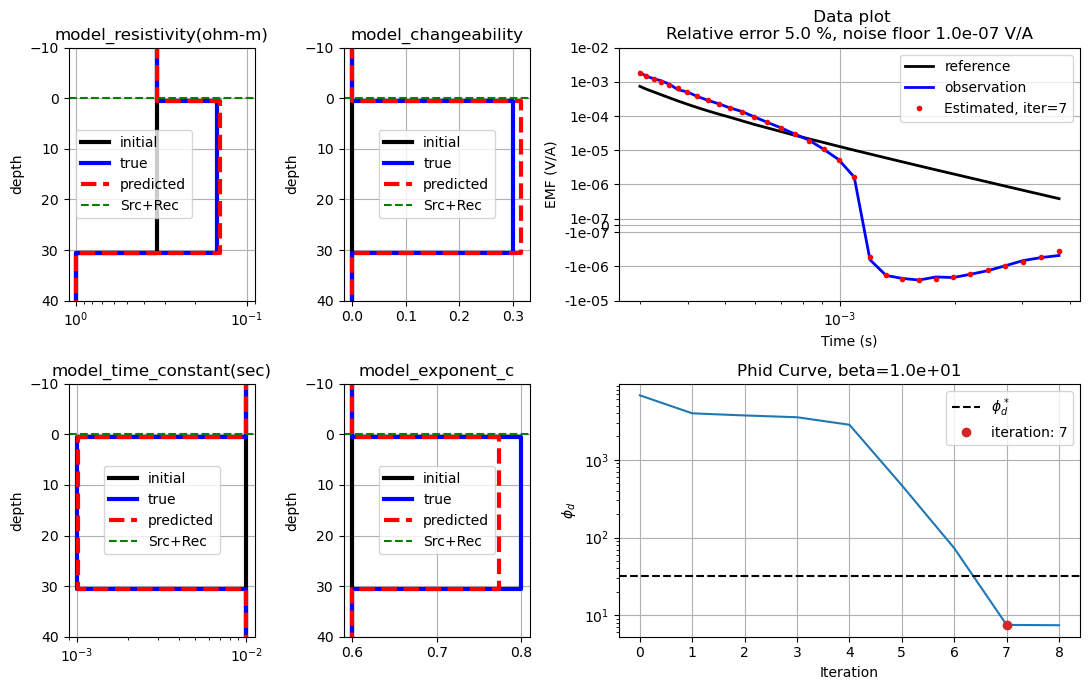

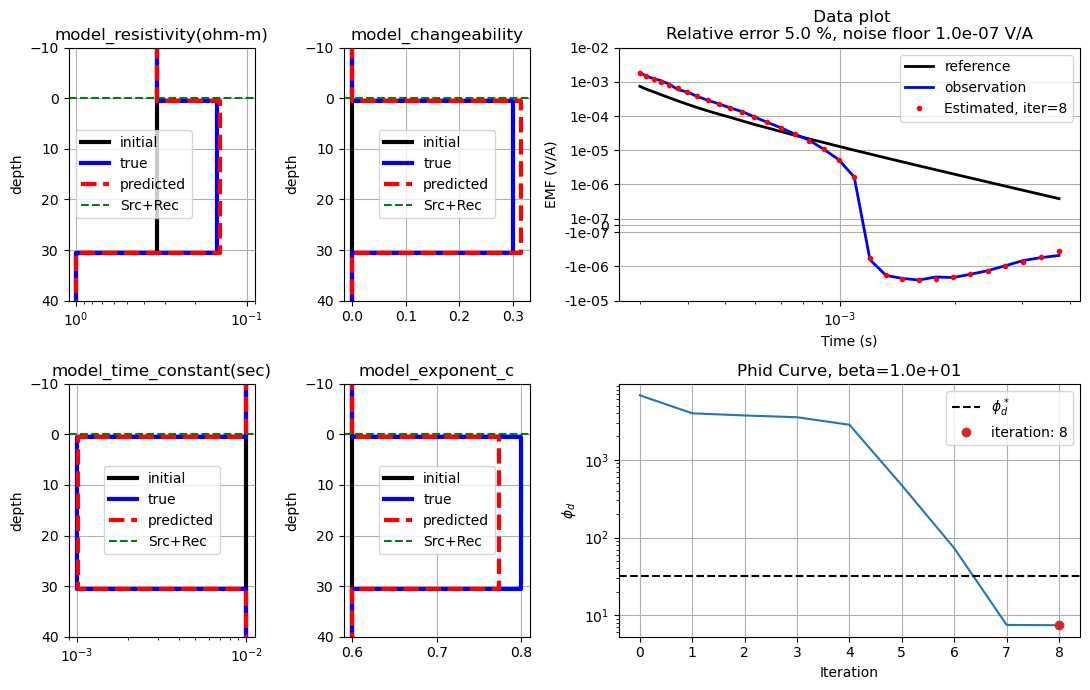

In [ ]:
index_list = np.arange(cmp_itr)
output_folder = 'images'
save_all_fields_images(index_list, output_folder= output_folder)


In [ ]:
def images_to_gif(image_folder, output_gif, duration=1000, resize=(320, 240)):
    # Get all the image files in the folder
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png') or f.endswith('.jpg')])
    # Open and resize the images
    images = [Image.open(os.path.join(image_folder, img)).resize(resize, Image.Resampling.LANCZOS) for img in image_files]
    # Save the images as an animated GIF
    images[0].save(output_gif, save_all=True, append_images=images[:], optimize=False, duration=duration, loop=0)


In [ ]:
# Provide the path to the input image folder, output video file, and desired duration (slower)
input_folder = r"images"
output_file = r"51_Inversion_1DIP.gif"
duration = 1000  # 1000 ms per frame (1 second per frame)
resize = (1100, 700)  # New resolution (width, height)
# Call the function to convert the images to a GIF
images_to_gif(image_folder=input_folder, output_gif=output_file, duration=duration, resize=resize)

In [ ]:
def delete_all_images(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        raise ValueError(f"The folder {folder_path} does not exist.")
    
    # Get the list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
    
    # Delete each image file
    for image_file in image_files:
        file_path = os.path.join(folder_path, image_file)
        try:
            os.remove(file_path)
            print(f"Deleted {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

# Provide the path to the folder containing images
image_folder = 'images'

# Call the function to delete all images in the folder
delete_all_images(image_folder)

Deleted images\000.png
Deleted images\001.png
Deleted images\002.png
Deleted images\003.png
Deleted images\004.png
Deleted images\005.png
Deleted images\006.png
Deleted images\007.png
Deleted images\008.png


# Object Function Grid!

In [33]:
def get_rm_grid(mrlim, mmlim, m_t, m_c, dobs, beta,
                ngrid=20, mirgin=0.1):
    # return grid of object function with respect to resistivity in high and low frequency
    # assuming IP model is pelton model tau and c are fixed value.

    mr_grid0 = (1+mirgin)*(np.min(mrlim)) - mirgin* (np.max(mrlim))
    mr_grid1 = (1+mirgin)*(np.max(mrlim)) - mirgin* (np.min(mrlim))
    mr_grid = np.linspace(mr_grid0, mr_grid1, ngrid)
    mm_grid0 = (1+mirgin)*(np.min(mmlim)) - mirgin* (np.max(mmlim))
    mm_grid1 = (1+mirgin)*(np.max(mmlim)) - mirgin* (np.min(mmlim))
    mm_grid = np.linspace(mm_grid0, mm_grid1, ngrid)
    fobj_rm_grid = np.zeros((ngrid, ngrid))

    for j, mr_tmp in enumerate(mr_grid):
        for i, mm_tmp in enumerate(mm_grid):
            mvec = np.r_[mr_tmp, mm_tmp, m_t, m_c]
            f_obj , phid, phim = DeepSea_TEMIP.objec_func(mvec,dobs,beta)
            fobj_rm_grid[i, j] = f_obj

    return fobj_rm_grid, mm_grid, mr_grid

In [34]:
def get_tc_grid(m_r, m_m, mtlim, mclim, dobs, beta
                , ngrid=20, mirgin=0.1):
    # return grid of object function with respect to resistivity in high and low frequency
    # assuming IP model is cole model tau and c are fixed value.
    mt_grid0 = (1+mirgin)*(np.min(mtlim)) - mirgin* (np.max(mtlim))
    mt_grid1 = (1+mirgin)*(np.max(mtlim)) - mirgin* (np.min(mtlim))
    mt_grid = np.linspace(mt_grid0, mt_grid1, ngrid)
    mc_grid0 = (1+mirgin)*(np.min(mclim)) - mirgin* (np.max(mclim))
    mc_grid1 = (1+mirgin)*(np.max(mclim)) - mirgin* (np.min(mclim))
    mc_grid = np.linspace(mc_grid0, mc_grid1, ngrid)
    fobj_tc_grid = np.zeros((ngrid, ngrid))

    for j, mt_tmp in enumerate(mt_grid):
        for i, mc_tmp in enumerate(mc_grid):
            mvec = np.r_[m_r, m_m, mt_tmp, mc_tmp]
            f_obj , phid, phim = DeepSea_TEMIP.objec_func(mvec,dobs,beta)
            fobj_tc_grid[i, j] = f_obj
    return fobj_tc_grid, mt_grid, mc_grid

In [35]:
itr_st = 0
mrlim = [ [ min(np.r_[mvec_itr[itr_st:,0],mvec_obs[0]]), 
            max(np.r_[mvec_itr[itr_st:,0],mvec_obs[0]])]]
mmlim = [ [ min(np.r_[mvec_itr[itr_st:,1],mvec_obs[1]]), 
            max(np.r_[mvec_itr[itr_st:,1],mvec_obs[1]])]]
mtlim = [ [ min(np.r_[mvec_itr[itr_st:,2],mvec_obs[2]]), 
            max(np.r_[mvec_itr[itr_st:,2],mvec_obs[2]])]]
mclim = [ [ min(np.r_[mvec_itr[itr_st:,3],mvec_obs[3]]), 
            max(np.r_[mvec_itr[itr_st:,3],mvec_obs[3]])]]
print(mrlim)
print(mmlim)
print(mtlim)
print(mclim)

[[-2.04741959074423, -0.9223180051538947]]
[[0.0, 0.37588170114733915]]
[[-7.3057568671896345, -4.605170185988091]]
[[0.5244082381658492, 0.8812239059044998]]


In [ ]:
ngrid = 50
mirgin = 0.1
m_t = mvec_itr[-1,2]
m_c = mvec_itr[-1,3]
rm_grid, mm_grid, mr_grid = get_rm_grid(
mrlim=mrlim, mmlim=mmlim, m_t=m_t, m_c=m_c, dobs=dobs,beta=beta
,ngrid=ngrid, mirgin=mirgin
) 

In [ ]:
m_r = mvec_itr[-1,0]
m_m = mvec_itr[-1,1]
tc_grid, mt_grid, mc_grid = get_tc_grid(
m_r=m_r, m_m=m_m, mtlim=mtlim, mclim=mclim, dobs=dobs, beta=beta
,ngrid=ngrid,mirgin=mirgin
) 

In [ ]:
res_grid = np.exp(mr_grid)
chg_grid = mm_grid
res_tr = np.exp(mvec_itr[itr_st:,0])
chg_tr = mvec_itr[itr_st:,1]
tau_grid = np.exp(mt_grid)
c_grid = mc_grid
tau_tr = np.exp(mvec_itr[itr_st:,2])
c_tr = mvec_itr[itr_st:,3]

In [ ]:
def plot_grid(ax, x_grid, y_grid, z_grid, x_label, y_label, trajectory, true_model, levels, cmap, norm, title=None):
    """
    Plot a contour grid with objective function levels.
    """
    CF = ax.contourf(x_grid, y_grid, z_grid, levels=levels, cmap=cmap, norm=norm)
    CS = ax.contour(x_grid, y_grid, z_grid, levels=levels, colors="w")
    
    # Format contour labels to scientific notation
    ax.clabel(CS, inline=True, fontsize=8, fmt="%.0e")
    
    # Colorbar setup
    CB = plt.colorbar(CF, ax=ax, format="%.0e")
    CB.set_label("Objective function value")
    
    # Plot inversion progress and true model
    ax.plot(*trajectory, "r", label="inversion progress")
    for i, (x, y) in enumerate(zip(trajectory[0], trajectory[1])):
        ax.text(x, y, str(i), fontsize=8, color='black', ha='center', va='bottom')
    ax.scatter(*true_model, color="magenta", marker="*", s=100,label="True model")
    
    # Axis scales and labels
    ax.set_xscale('log')
    ax.set_yscale('linear')
    ax.invert_xaxis()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if title:
        ax.set_title(title)
    ax.legend()
#    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


In [ ]:
def plot_patterns(res_grid, chg_grid, rm_grid, tau_grid, c_grid, tc_grid, 
                  res_tr, chg_tr, tau_tr, c_tr, mvec_obs, dpi=100, nlevels=10):
    """
    Plot two patterns: (res, charge) and (tau, c).
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # use same contour for resistivity VS chargeability and time constant VS exponent c
    levels = np.logspace(np.log10(np.min(np.r_[rm_grid,tc_grid])), np.log10(np.max(np.r_[rm_grid,tc_grid])), nlevels)

    # Create a logarithmic colormap
    cmap = plt.cm.Blues
    res_norm = mcolors.LogNorm(vmin=np.min(rm_grid), vmax=np.max(rm_grid))
    tau_norm = mcolors.LogNorm(vmin=np.min(tc_grid), vmax=np.max(tc_grid))
    
    # Plot resistivity vs chargeability
    plot_grid(ax[0], res_grid, chg_grid, rm_grid, 
              "Resistivity (ohm-m)", "Chargeability", 
              trajectory=(res_tr, chg_tr), 
              true_model=(np.exp(mvec_obs[0]), mvec_obs[1]),
              levels=levels, cmap=cmap, norm=res_norm, title="Resistivity vs Chargeability")
    
    # Plot time constant vs exponent c
    plot_grid(ax[1], tau_grid, c_grid, tc_grid, 
              "Time constant (sec)", "Exponent c", 
              trajectory=(tau_tr, c_tr), 
              true_model=(np.exp(mvec_obs[2]), mvec_obs[3]),
              levels=levels, cmap=cmap, norm=tau_norm, title="Time constant vs Exponent c")
    

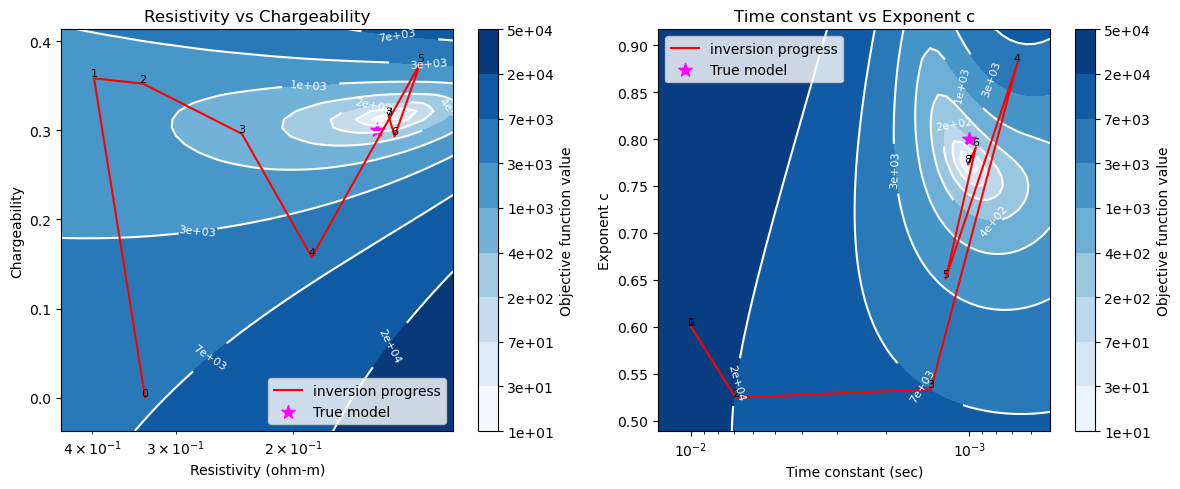

In [ ]:
# Call the function with your data
plot_patterns(
    res_grid, chg_grid, rm_grid, 
    tau_grid, c_grid, tc_grid, 
    res_tr, chg_tr, tau_tr, c_tr, 
    mvec_obs, dpi=100, nlevels=10
)
plt.tight_layout()
plt.savefig("51_objgrid.png", dpi=dpi)
plt.show()
